# Customer2Vec

We learn good semantic representations for customers (users) from transactional data using doc2vec. Each customer is a document, orders are sentences, and products are words. We also compare Customer2Vec with the baseline representations obtained using k-means on manually designed features. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 8


## Data Exploration and Preparation

In [12]:
os.chdir(r'N:/ALGORITHMIC MARKETING/Assignment4/data/instacart-market-basket-analysis')

In [13]:
#DATA_PATH = 'data/instacart-market-basket-analysis/'
files_list = glob.glob(f'*.csv')

files_list

['aisles.csv',
 'departments.csv',
 'orders.csv',
 'order_products__prior.csv',
 'order_products__train.csv',
 'products.csv']

In [14]:
data_dict = {}

for file in files_list:
    print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    print(data.info(null_counts=True))
    data_dict[file.split('.')[0].split('/')[-1]] = data

print(f'Loaded data sets - {data_dict.keys()}')



Reading: aisles.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None


Reading: departments.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes
None


Reading: orders.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  3421083 non-null int64
user_id                   3421083 non-null int64
eval_set                  3421083 non-null object
order_number              3421083 non-null int64
order_dow                 3421083 non-null int64
order_hour_of_day         3421083 non-null int64
days_since_prior_order    3214874 non-null float64
dtypes: float64(

## Establishing the Baselines: Basic Segmentation in a Manually Designed Feature Space

We start with designing several basic features and segmenting customers using this basic representation. Note that the dataset is also very limited and does not allow for advanced ferature engineering (there is no demographic data, etc). 

### Feature Engineering

In [15]:
train_orders = data_dict['order_products__train']
prior_orders = data_dict['order_products__prior']
products = data_dict['products'].set_index('product_id')

orders = data_dict['orders']
prior_orders = prior_orders.merge(right=orders[['user_id','order_id','order_number']],on='order_id',how='left')

prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


In [16]:
# Sample users to keep the problem computationaly tractable 
USER_SUBSET = 50000
np.random.seed(42)
user_ids_sample = prior_orders['user_id'].sample(n=USER_SUBSET, replace=False)

In [17]:
prior_orders_details = prior_orders[prior_orders.user_id.isin(user_ids_sample)].copy()
prior_orders_details['product_id'] = prior_orders_details['product_id'].astype(int)
prior_orders_details = prior_orders_details.merge(data_dict['products'], on='product_id', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['aisles'], on='aisle_id', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['departments'], on='department_id', how='left')

prior_orders_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,product_name,aisle_id,department_id,aisle,department
0,4,46842,1,0,178520,36,Plain Pre-Sliced Bagels,93,3,breakfast bakery,bakery
1,4,26434,2,1,178520,36,Honey/Lemon Cough Drops,11,11,cold flu allergy,personal care
2,4,39758,3,1,178520,36,Chewy 25% Low Sugar Chocolate Chip Granola,3,19,energy granola bars,snacks
3,4,27761,4,1,178520,36,Oats & Chocolate Chewy Bars,48,14,breakfast bars pastries,breakfast
4,4,10054,5,1,178520,36,Kellogg's Nutri-Grain Apple Cinnamon Cereal,48,14,breakfast bars pastries,breakfast


In [18]:
# Create basic user features: relative purchase frequences in each depertment/aisle

feature_department = pd.pivot_table(prior_orders_details, index=['user_id'], values=['product_id'], columns=['department'], aggfunc='count', fill_value=0)
feature_department = feature_department.div(feature_department.sum(axis=1), axis=0)
feature_department.columns = feature_department.columns.droplevel(0)
feature_department = feature_department.reset_index()

feature_aisle = pd.pivot_table(prior_orders_details, index=['user_id'], values=['product_id'], columns=['aisle'], aggfunc='count', fill_value=0)
feature_aisle = feature_aisle.div(feature_aisle.sum(axis=1), axis=0)
feature_aisle.columns = feature_aisle.columns.droplevel(0)
feature_aisle = feature_aisle.reset_index()

feature_df = feature_department.merge(feature_aisle, how='left', on='user_id').set_index('user_id')

feature_df.iloc[:5, :10] # show first 10 columns (departments) only

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta
user_id,,,,,,,,,,
2,0.000000,0.000000,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000
7,0.000000,0.000000,0.024272,0.247573,0.000000,0.0,0.029126,0.155340,0.063107,0.000000
9,0.000000,0.078947,0.052632,0.105263,0.039474,0.0,0.013158,0.315789,0.039474,0.000000
17,0.119048,0.000000,0.034014,0.200680,0.017007,0.0,0.040816,0.149660,0.023810,0.017007
21,0.053659,0.000000,0.029268,0.243902,0.014634,0.0,0.000000,0.248780,0.004878,0.004878


In [19]:
len(feature_df.columns)

155

### Visualize the Basic Space Using t-SNE  

In [20]:
from sklearn.preprocessing import MinMaxScaler

mm_scale = MinMaxScaler()
feature_df_scale = pd.DataFrame(mm_scale.fit_transform(feature_df),
                                columns=feature_df.columns,
                                index=feature_df.index.values)

tsne_doc_features = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_features_doc = tsne_doc_features.fit_transform(feature_df_scale.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38240 samples in 9.813s...
[t-SNE] Computed neighbors for 38240 samples in 988.703s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38240
[t-SNE] Computed conditional probabilities for sample 2000 / 38240
[t-SNE] Computed conditional probabilities for sample 3000 / 38240
[t-SNE] Computed conditional probabilities for sample 4000 / 38240
[t-SNE] Computed conditional probabilities for sample 5000 / 38240
[t-SNE] Computed conditional probabilities for sample 6000 / 38240
[t-SNE] Computed conditional probabilities for sample 7000 / 38240
[t-SNE] Computed conditional probabilities for sample 8000 / 38240
[t-SNE] Computed conditional probabilities for sample 9000 / 38240
[t-SNE] Computed conditional probabilities for sample 10000 / 38240
[t-SNE] Computed conditional probabilities for sample 11000 / 38240
[t-SNE] Computed conditional probabilities for sample 12000 / 38240
[t-SNE] Computed conditional probabilities for s

In [21]:
tsne_doc_features = pd.DataFrame({'user_id':feature_df.index.values})
tsne_doc_features['tsne-2d-one'] = tsne_features_doc[:,0]
tsne_doc_features['tsne-2d-two'] = tsne_features_doc[:,1]

<Figure size 864x864 with 0 Axes>

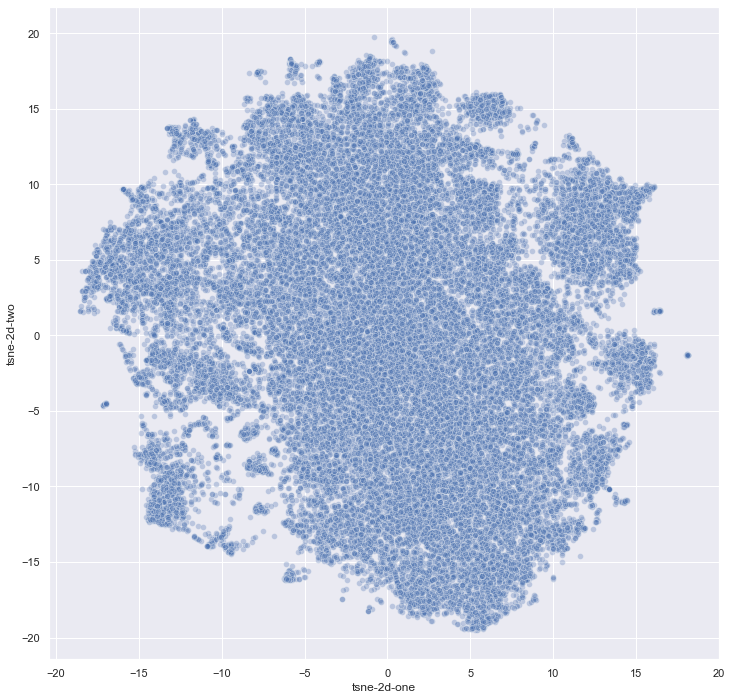

In [23]:
plt.figure(figsize=(12, 12))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc_features,
    legend="full",
    alpha=0.3
)
plt.show()

In [24]:
# Computing silhouette scores for different clustering option
silhouette_list = []
for k in tqdm(range(2, 12, 2)):
    clusters = KMeans(n_clusters=k).fit(feature_df_scale).labels_.astype(float)
    silhouette_avg = silhouette_score(feature_df_scale, clusters, metric="euclidean")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

C:\Users\nikhi\Anaconda3\envs\reco_gpu\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Silhouette score for 2 clusters is : 0.115
Silhouette score for 4 clusters is : 0.05037
Silhouette score for 6 clusters is : 0.04059
Silhouette score for 8 clusters is : 0.04725
Silhouette score for 10 clusters is : 0.02476



<Figure size 720x432 with 0 Axes>

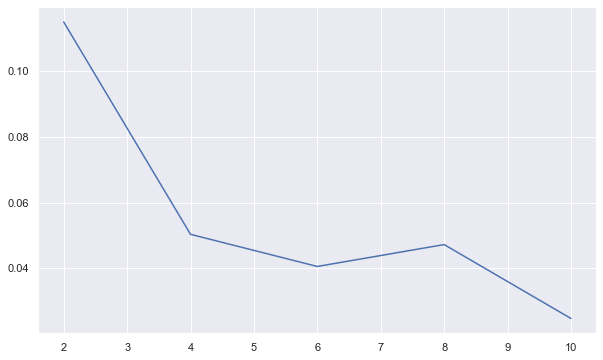

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 12, 2), silhouette_list)

Conclusions: We can see from the t-SNE visualization it is possible to detect 2-3 clusters, but the silhouette score is close to zero and this feature space is not a good choice for customer segmentation. 
We should develop more advanced features and incorporate more domain knowledge to obtain better feature space for segmentation.

## Customer2Vec, Step 1: Data Preparation 

In this and next section, we are learning and exploring the customer semantic space using Doc2Vec.

In [26]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

# It is important to sort order and products chronologically
prior_orders.sort_values(by=['user_id','order_number','add_to_cart_order'], inplace=True)

In [27]:
combined_orders_by_user_id = prior_orders.groupby("user_id").apply(lambda order: ' '.join(order['product_id'].tolist()))

combined_orders_by_user_id = pd.DataFrame(combined_orders_by_user_id,columns=['all_orders'])
print(f'Number of orders: {combined_orders_by_user_id.shape[0]}')
combined_orders_by_user_id.reset_index(inplace=True)
combined_orders_by_user_id.user_id = combined_orders_by_user_id.user_id.astype(str)

combined_orders_by_user_id.head()

Number of orders: 206209


,user_id,all_orders
0,1,196 14084 12427 26088 26405 196 10258 12427 13176 26088 13032 196 12427 10258 25133 30450 196 12427 10258 25133 26405 196 12427 10258 25133 10326 17122 41787 13176 196 12427 10258 25133 196 10258 12427 25133 13032 12427 196 10258 25133 46149 49235 49235 46149 25133 196 10258 12427 196 46149 39657 38928 25133 10258 35951 13032 12427
1,2,32792 47766 20574 12000 48110 22474 16589 35917 27344 30489 27966 13176 45066 16797 47526 8479 47766 19051 8138 47766 32792 20574 7781 28874 49451 32792 32139 34688 36735 37646 22829 24852 47209 33276 45613 9681 21150 47144 5322 17224 38656 21376 48210 5907 14553 47553 22124 19156 1559 47766 32792 12000 9681 32139 32052 27344 24852 45066 27966 47209 36735 46676 33754 17872 18523 24954 4957 40571 41787 19051 33276 32792 12000 16589 32052 19051 32139 47209 24852 46886 40198 17758 45066 41787 3...
2,3,9387 17668 15143 16797 39190 47766 21903 39922 24810 32402 38596 21903 248 40604 8021 17668 21137 23650 32402 39190 47766 21903 49683 28373 7503 1819 12845 9387 16965 24010 39190 9387 17668 47766 16965 28373 21903 22035 42265 18370 44683 22035 39190 9387 47766 1819 24810 14992 44683 39190 1819 21903 43961 16797 24010 14992 18599 9387 39190 22035 43961 18599 21903 47766 42557 48523 39190 47766 16797 43961 48523 18599 17668 47766 39190 1005 32402 39190 47766 21903 43961 17668 39190 18599 23650...
3,4,36606 7350 35469 2707 42329 7160 1200 17769 43704 37646 11865 35469 19057 22199 25146 26576 25623 21573
4,5,15349 21413 48775 28289 8518 11777 31717 26604 43693 22475 24535 43693 6808 24535 11777 21616 18761 26604 13870 13988 26604 11777 20754 24231 40706 27344 24535 43693 40706 16168 21413 13988 3376 8518 26604 11777 5999


## Customer2Vec, Step 2: Train Doc2Vec model

We use implementation from Gensim adjusting the following parameters:
* documents = users (each user is represented by a chronologically sorted list of products)
* window - Maximum distance between the current and predicted word within a sentence.
* vector_size - Dimensionality of the word vectors.
* min_count - Ignores all words with total frequency lower than this.

Note that model training can take a long time (10+ hours).

In [31]:
TRAIN_USER_MODEL = False    # True - create a new model, False - load a previosuly created model
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [33]:
from gensim.models.doc2vec import LabeledSentence, TaggedDocument, Doc2Vec
import timeit
import gensim

embeddings_dim = 100    # dimensionality of user representation

filename = f'models/customer2vec.{embeddings_dim}d.model'
if TRAIN_USER_MODEL:

    class TaggedDocumentIterator(object):
        def __init__(self, df):
           self.df = df
        def __iter__(self):
            for row in self.df.itertuples():
                yield TaggedDocument(words=dict(row._asdict())['all_orders'].split(),tags=[dict(row._asdict())['user_id']])

    it = TaggedDocumentIterator(combined_orders_by_user_id)

    doc_model = gensim.models.Doc2Vec(vector_size=embeddings_dim, 
                                      window=5, 
                                      min_count=10, 
                                      workers=mp.cpu_count(),
                                      alpha=0.055, 
                                      min_alpha=0.055,
                                      epochs=10)   # use fixed learning rate

    train_corpus = list(it)

    doc_model.build_vocab(train_corpus)

    for epoch in tqdm(range(10)):
        doc_model.alpha -= 0.005                    # decrease the learning rate
        doc_model.min_alpha = doc_model.alpha       # fix the learning rate, no decay
        doc_model.train(train_corpus, total_examples=doc_model.corpus_count, epochs=doc_model.iter)
        print('Iteration:', epoch)

    doc_model.save(filename)
    print(f'Model saved to [{filename}]')
    
else:
    doc_model = Doc2Vec.load(filename)
    print(f'Model loaded from [{filename}]')

C:\Users\nikhi\Anaconda3\envs\reco_gpu\lib\site-packages\ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\nikhi\Anaconda3\envs\reco_gpu\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9

Model saved to [models/customer2vec.100d.model]


In [34]:
vocab_doc = list(doc_model.docvecs.doctags.keys())
doc_vector_dict = {arg:doc_model.docvecs[arg] for arg in vocab_doc}
X_doc = pd.DataFrame(doc_vector_dict).T.values


X_doc.shape, len(vocab_doc), prior_orders["user_id"].nunique()

((206209, 100), 206209, 206209)

## Customer2Vec, Step 3: Visualize the Customer Semantic Space Using t-SNE

In [35]:
user_ids_sample_str = set([str(id) for id in user_ids_sample])
idx = []
for i, user_id in enumerate(doc_vector_dict):
    if user_id in user_ids_sample_str:
        idx.append(i)
X_doc_subset = X_doc[idx] # only sampled user IDs
X_doc_subset.shape

(38240, 100)

In [36]:
doc_vec_subset = pd.DataFrame(doc_vector_dict).T.iloc[idx]
doc_vec_subset.shape

(38240, 100)

In [37]:
from sklearn.metrics import pairwise_distances

distance_matrix_doc = pairwise_distances(X_doc_subset, X_doc_subset, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38240 samples in 2.505s...
[t-SNE] Computed neighbors for 38240 samples in 303.551s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38240
[t-SNE] Computed conditional probabilities for sample 2000 / 38240
[t-SNE] Computed conditional probabilities for sample 3000 / 38240
[t-SNE] Computed conditional probabilities for sample 4000 / 38240
[t-SNE] Computed conditional probabilities for sample 5000 / 38240
[t-SNE] Computed conditional probabilities for sample 6000 / 38240
[t-SNE] Computed conditional probabilities for sample 7000 / 38240
[t-SNE] Computed conditional probabilities for sample 8000 / 38240
[t-SNE] Computed conditional probabilities for sample 9000 / 38240
[t-SNE] Computed conditional probabilities for sample 10000 / 38240
[t-SNE] Computed conditional probabilities for sample 11000 / 38240
[t-SNE] Computed conditional probabilities for sample 12000 / 38240
[t-SNE] Computed conditional probabilities for s

In [38]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

<Figure size 864x864 with 0 Axes>

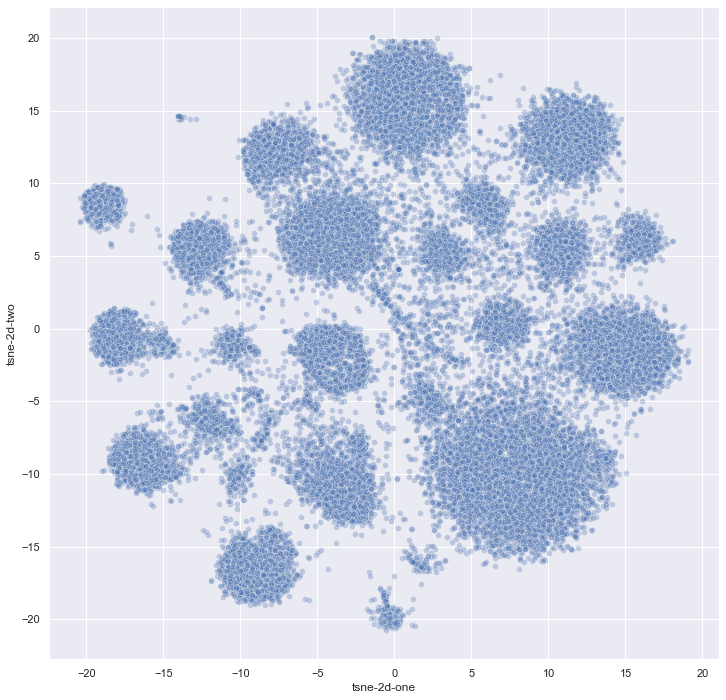

In [39]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.3
)
plt.show()

## Customer2Vec, Step 4: Segmentation in the Customer Semantic Space Using t-SNE

In [40]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc_subset)).labels_.astype(float)

silhouette_list = []
for k in tqdm(range(2, 22, 1)):
    latent_clusters = cluster_cosine(X_doc_subset, k)
    silhouette_avg = silhouette_score(X_doc_subset, latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

C:\Users\nikhi\Anaconda3\envs\reco_gpu\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Silhouette score for 2 clusters is : 0.05885
Silhouette score for 3 clusters is : 0.06073
Silhouette score for 4 clusters is : 0.06051
Silhouette score for 5 clusters is : 0.06244
Silhouette score for 6 clusters is : 0.06577
Silhouette score for 7 clusters is : 0.06766
Silhouette score for 8 clusters is : 0.0741
Silhouette score for 9 clusters is : 0.07765
Silhouette score for 10 clusters is : 0.08163
Silhouette score for 11 clusters is : 0.08884
Silhouette score for 12 clusters is : 0.09229
Silhouette score for 13 clusters is : 0.09469
Silhouette score for 14 clusters is : 0.09727
Silhouette score for 15 clusters is : 0.08989
Silhouette score for 16 clusters is : 0.09547
Silhouette score for 17 clusters is : 0.09643
Silhouette score for 18 clusters is : 0.09232
Silhouette score for 19 clusters is : 0.1002
Silhouette score for 20 clusters is : 0.1011
Silhouette score for 21 clusters is : 0.1006



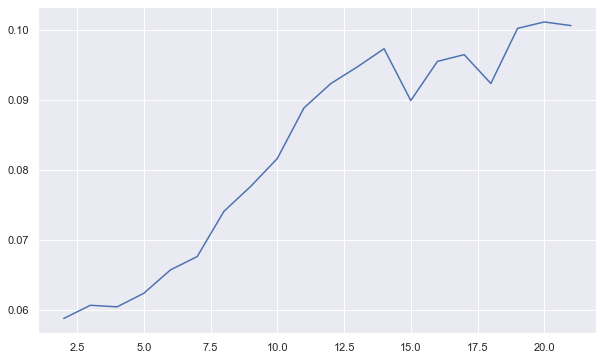

In [41]:
plt.figure(figsize=(10,6))
plt.plot(range(2,22,1), silhouette_list);

In [42]:
N_CLUSTER = 12

latent_clusters = cluster_cosine(X_doc_subset, N_CLUSTER)
doc_vec_end = doc_vec_subset.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

doc_vec_end['label'].value_counts()

8.0     7158
1.0     6730
9.0     4379
0.0     3364
2.0     3145
5.0     2972
3.0     2661
4.0     1875
10.0    1795
6.0     1443
11.0    1430
7.0     1288
Name: label, dtype: int64

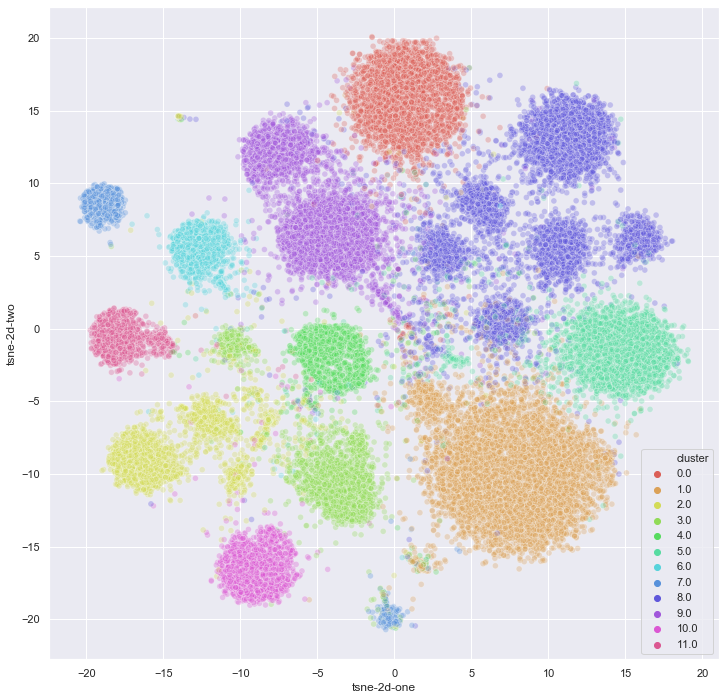

In [43]:
plt.figure(figsize=(12, 12))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.3
);
plt.show();

In [44]:
feature_df['latent_cluster'] = latent_clusters

department_names = np.setdiff1d(prior_orders_details['department'].unique(), ['other', 'missing'])
interpetation_department = feature_df.groupby('latent_cluster')[department_names].mean()

interpetation_department.T.div(interpetation_department.sum(axis=1)).round(3)

latent_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
alcohol,0.000,0.001,0.008,0.008,0.014,0.000,0.001,0.029,0.000,0.000,0.000,0.057
babies,0.013,0.013,0.009,0.009,0.001,0.017,0.013,0.008,0.015,0.013,0.022,0.004
bakery,0.021,0.046,0.048,0.048,0.029,0.038,0.031,0.053,0.029,0.022,0.043,0.045
beverages,0.062,0.079,0.102,0.103,0.126,0.089,0.083,0.105,0.069,0.062,0.119,0.115
breakfast,0.018,0.018,0.030,0.029,0.026,0.019,0.030,0.021,0.016,0.019,0.037,0.027
bulk,0.001,0.002,0.000,0.000,0.003,0.001,0.000,0.000,0.001,0.001,0.000,0.000
canned goods,0.037,0.031,0.045,0.034,0.018,0.029,0.037,0.031,0.034,0.034,0.030,0.036
dairy eggs,0.169,0.189,0.152,0.164,0.114,0.164,0.181,0.178,0.167,0.169,0.151,0.141
deli,0.033,0.042,0.026,0.029,0.020,0.034,0.022,0.035,0.035,0.033,0.024,0.019
dry goods pasta,0.030,0.025,0.035,0.028,0.007,0.024,0.035,0.029,0.025,0.029,0.032,0.027


In [45]:
interpetation_aisle = feature_df.groupby('latent_cluster')[feature_df.columns.values[16:-1]].mean()
interpetation_aisle.T.div(interpetation_aisle.sum(axis=1)).round(3).head(20)

latent_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
pantry,0.036,0.037,0.056,0.047,0.033,0.037,0.049,0.045,0.037,0.036,0.047,0.050
personal care,0.005,0.007,0.014,0.018,0.005,0.010,0.009,0.013,0.007,0.006,0.037,0.008
pets,0.001,0.001,0.005,0.005,0.001,0.001,0.003,0.007,0.001,0.000,0.009,0.004
produce,0.242,0.214,0.135,0.135,0.235,0.210,0.166,0.132,0.230,0.244,0.081,0.133
snacks,0.047,0.055,0.067,0.070,0.085,0.065,0.070,0.070,0.055,0.049,0.083,0.070
air fresheners candles,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.001
asian foods,0.003,0.004,0.004,0.004,0.001,0.004,0.005,0.004,0.003,0.003,0.003,0.003
baby accessories,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
baby bath body care,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000
baby food formula,0.008,0.008,0.005,0.005,0.001,0.010,0.008,0.005,0.010,0.008,0.013,0.001


In [46]:
prior_orders_details_clustered = prior_orders_details.copy()
prior_orders_details_clustered = prior_orders_details_clustered.merge(feature_df['latent_cluster'], on='user_id', how='left')

for cluster_id in [7.0, 3.0]:
    prior_orders_details_clustered[prior_orders_details_clustered['latent_cluster']==cluster_id][['user_id', 'product_name']].groupby("user_id").apply(lambda order: ' > '.join(order['product_name'])).reset_index().head(5)

,user_id,0
0,630,"Gluten Free Rice Chex > French Vanilla Creamer > Turkey Breast Thin Sliced Honey Roasted Deli Select > Ultra Thin Oven Roasted Turkey Breast > Yoghurt Blueberry > Milk, Fat Free > Turkey Breast Thin Sliced Honey Roasted Deli Select > Sharp Cheddar Deli Sliced Cheese > Ultra Thin Oven Roasted Turkey Breast > 100% Whole Wheat Bread > Yoghurt Blueberry > Tart Cherry Yoghurt > Organic Fuji Apple > Honey Nut Cheerios > Original Soy Milk > Sriracha Hot Chili Sauce > French Vanilla Creamer > Milk, ..."
1,787,Diet Coke Caffeine Free Soda > No Calorie Sweetener Packets > Pure & Smooth Green Tea > Macaroni & Cheese > smartwater® Electrolyte Enhanced Water > Pure & Smooth Green Tea > smartwater® Electrolyte Enhanced Water > Diet Coke Caffeine Free Soda > Anti Viral Upright Facial Tissue > Organic 2% Reduced Fat Milk > Diet Coke Caffeine Free Soda > Pure & Smooth Green Tea > Electrolyte Enhanced Water > Premium Ice Cubes > Macaroni & Cheese > Philadelphia Cream Cheese > Pure & Smooth Green Tea > Diet...
2,935,"Double Stuf Golden Sandwich Cookies > Bag of Organic Bananas > Blueberries > Vitamin D Organic Milk > Lowfat Vanilla Milk > Organic YoBaby Vanilla Yogurt > Organic Plain Whole Milk Yogurt > Plain Greek Yogurt > Peach, Apricot & Banana Stage 2 Baby Food > Broccoli & Apple Stage 2 Baby Food > Blueberry Oats and Quinoa Whole Grain Snack > Stage 2 Sweet Potato Corn & Apple Baby Food > Miniature Peanut Butter Cups > Chunk Light Tuna in Water > Kosher Dill Halves Pickles > The Original Multi Grai..."
3,975,"Organic Large Grade AA Brown Eggs > Country White Bread > Organic Reduced Fat 2% Milk > Organic European Style Lightly Salted Butter > Mini Naan > Pizza, Naan, Artisan Crust, Spinach & Paneer Cheese > Pop-Tarts Frosted Brown Sugar Cinnamon Pastries > Unsweetened Almondmilk > Sake > Organic Large Grade AA Brown Eggs > Organic Reduced Fat 2% Milk > Mini Naan > Beef Flavor Ramen Noodle Soup > Organic Green Cabbage > Country White Bread > Mini Naan > Green Tea With Ginseng and Honey > Apple Sauc..."
4,1107,"Vine Ripe Tomatoes > Organic Cucumber > Organic Large Grade AA Omega-3 Eggs > Organic Red Radish, Bunch > Brown & Serve Original Breakfast Sausage Links > French Roast Ground Coffee > Organic Milk Reduced Fat, 2% Milkfat > Half & Half > Philadelphia Original Cream Cheese > Organic Large Grade AA Omega-3 Eggs > Limes > Cookies, Chocolate Chip Walnut > Extra Crisp English Muffins > Organic Seasoned Yukon Select Potatoes Hashed Browns > Blueberry Morning Blueberry Cereal > Picante Tomato Cockta..."


,user_id,0
0,17,"Natural Lime Flavor Sparkling Mineral Water > Grade A Extra Large Eggs > Light Oaked Chardonnay > Compleats Chicken Breast Gravy Mashed Potatoes Microwaveable Meal > Quick 1 Minute Oatmeal > Chili Sauce > Natural Lime Flavor Sparkling Mineral Water > Grade A Extra Large Eggs > Sparkling Mineral Water, Natural Lemon Flavor > Classic Roast Instant Coffee Crystals > Ultra Thin Slices Swiss Cheese > Diet Pepsi Slim Cans > Vanilla Chocolate Chip Ice Cream > Tender white meat turkey, pasta, mushro..."
1,21,"Natural Almonds 100 Calorie Packs > India Pale Ale > 12 Oz Lager > Total 2% All Natural Greek Strained Yogurt with Honey > Total 2% with Strawberry Lowfat Greek Strained Yogurt > Organic Gala Apples > Eggs, Hard-Boiled > Stoli Blueberi > Plain Pre-Sliced Bagels > Wasabi Roasted Seaweed Snacks > Chewy Chocolate Chip Granola Bars > Slim Can Pink Grapefruit Natural Mineral Water > Canned Aranciata Orange > Unsweetened Premium Iced Tea > Dairy Free Coconut Milk Vanilla Bean Frozen Dessert > Choc..."
2,58,"Spanish Style Ready Rice > Dressing, Jersey Sweet Onion, Calorie Free > Fresh Cut Golden Sweet Whole Kernel Corn > Light Red Kidney Beans > Crushed Tomatoes > 99% Fat Free Chicken Broth > Cosmic Brownies With Chocolate Chip Candy > 100% Natural Diced Tomatoes > Jasmine Rice > Tomato Sauce > With Pineapple Pulp Free Orange Juice > Organic Yellow Onion > 93% Lean Ground Turkey > Light Red Kidney Beans > Fresh Cut Golden Sweet No Salt Added Whole Kernel Corn > Mexican Style Four Cheese Shredded..."
3,111,Berry Berry Good Lemonade Organic Juice Drink > Low fat Chocolate Milk > 100% Whole Wheat Medium Soft Taco Flour Tortillas > Reduced Fat 4 Cheese Mexican Shredded Cheese > Organic Raw Unfiltered Apple Cider Vinegar > 100% Whole Wheat Bread > Chocolate Chip Muffin & Quick Bread Mix > Breakfast Claws > Beef Marinade > Breakfast Links Maple & Smoked Bacon Smoked Chicken Sausage > Turkey Bacon > Artichokes > Organic Fat-Free Milk > Double Zipper Gallon Storage Bags > Quart Storage Bags > Pepperm...
4,154,"Multi Use Wood Cleaner Oil Soap With Orange Oil > Multi-Surface Cleaner Lemon Fresh > Total All Purpose Grease Cutting Lemon Cleanser > Mold and Mildew Remover with Bleach > Lemon Clean Furniture Spray > Antibacterial Kitchen All Purpose Spray Cleaner, Lemon Fresh > Crystal Rain Trigger Glass Cleaner > 100% Apple Juice > Reduced Fat Super Chunk Peanut Butter > Caffe Verona Dark Keurig Brewed K-Cups Ground Coffee > Santa Cruz Sourdough > Pepperidge Farm Colors Cheddar Baked Snack Crackers > T..."


Conclusions: Cluster 7 is clearly characterized by healthy products (vegetables, nonfat dairy, vitamins, etc). Cluster 3 has significant percentage of high-calorie products (sausage, bananas, frozen desserts, ice cream, pasta sause, etc).   